<a href="https://colab.research.google.com/github/Dahuginn/-NLP-NewsClustering/blob/main/%5BNLP%5DNewsClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты

In [ ]:
!pip install natasha
!pip install corus

In [ ]:
from natasha import MorphVocab
from natasha import Segmenter, NewsEmbedding, NewsMorphTagger, NewsSyntaxParser, Doc
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

!wget https://github.com/buriy/russian-nlp-datasets/releases/download/r4/news-articles-2014.tar.bz2

In [2]:
import pandas as pd
import numpy as np

from corus import load_buriy_news

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE


import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

# Кластеризация новостей

In [8]:
path = 'news-articles-2014.tar.bz2'
records = load_buriy_news(path)

In [9]:
a = list(records)
a[0]

BuriyRecord(
    timestamp=datetime.datetime(2014, 8, 22, 15, 15),
    url='http://www.ntv.ru/novosti/1200239/',
    edition=None,
    topics='novosti',
    title='Россияне на юношеских Олимпийских играх в пятницу завоевали восемь медалей',
    text='В пятницу российские спортсмены на\nюношеских Олимпийских играх в китайском Нанкине\nзавоевали еще восемь наград \x97 две золотые, три серебряные и три бронзовые.\nТяжелоатлет Хетаг Хугаев завоевал золото в весовой категории до 85 кг. Розалия Насретдинова первенствовала в плавании на дистанции 50 метров вольным стилем.\nЕвгений Рылов принес россиянам серебро в плавании на дистанции 200 метров на спине. Он же вместе с Александром Садовниковым, Розалией Насретдиновой и Дарьей Устиновой стал вторым в смешанной комбинированной эстафете 4х100 м.\nШтангистка Светлана Щербакова завоевала серебро в весовой категории свыше 63 кг.\nКроме того, та же Дарья Устинова завоевала бронзу в плавании на дистанции 50 м вольным стилем, а Антон Чупков \x97 нагр

In [10]:
df = pd.DataFrame()
df['timestamp'] = [i.timestamp for i in a]
df['url'] = [i.url for i in a]
df['edition'] = [i.edition for i in a]
df['topics'] = [i.topics for i in a]
df['title'] = [i.title for i in a]
df['text'] = [i.text for i in a]

In [11]:
df.head()

,timestamp,url,edition,topics,title,text
0,2014-08-22 15:15:00,http://www.ntv.ru/novosti/1200239/,None,novosti,Россияне на юношеских Олимпийских играх в пятн...,В пятницу российские спортсмены на\nюношеских ...
1,2014-08-22 14:50:00,http://www.ntv.ru/novosti/1200318/,None,novosti,Российские журналисты попали под минометный об...,"Пётр Михайлов\n, сотрудник пресс-службы провоз..."
2,2014-08-22 14:49:00,http://www.ntv.ru/novosti/1200315/,None,novosti,ЕС призывает РФ вывести гуманитарный конвой с ...,"Себастьен Брабант\n, представитель ЕС: «Мы сож..."
3,2014-08-22 14:49:00,http://www.ntv.ru/novosti/1200321/,None,novosti,Яценюк: у нас есть своя гуманитарная помощь,"Арсений Яценюк заявил, что Украина не нуждаетс..."
4,2014-08-22 14:33:00,http://www.ntv.ru/novosti/1200320/,None,novosti,Музей варежки открывает выставку художника-инв...,Сегодня в петербургском музее варежки открылас...


In [12]:
df['topics'].fillna('no topic', inplace=True)

In [13]:
# будем работать с маленьким корпусом для скорости
shortened_df = df[:2000]

In [14]:
topics = np.unique(shortened_df['topics'])
counts = [len(shortened_df[shortened_df['topics'] == i]) for i in topics]

In [15]:
dictionary = dict(zip(counts, topics))

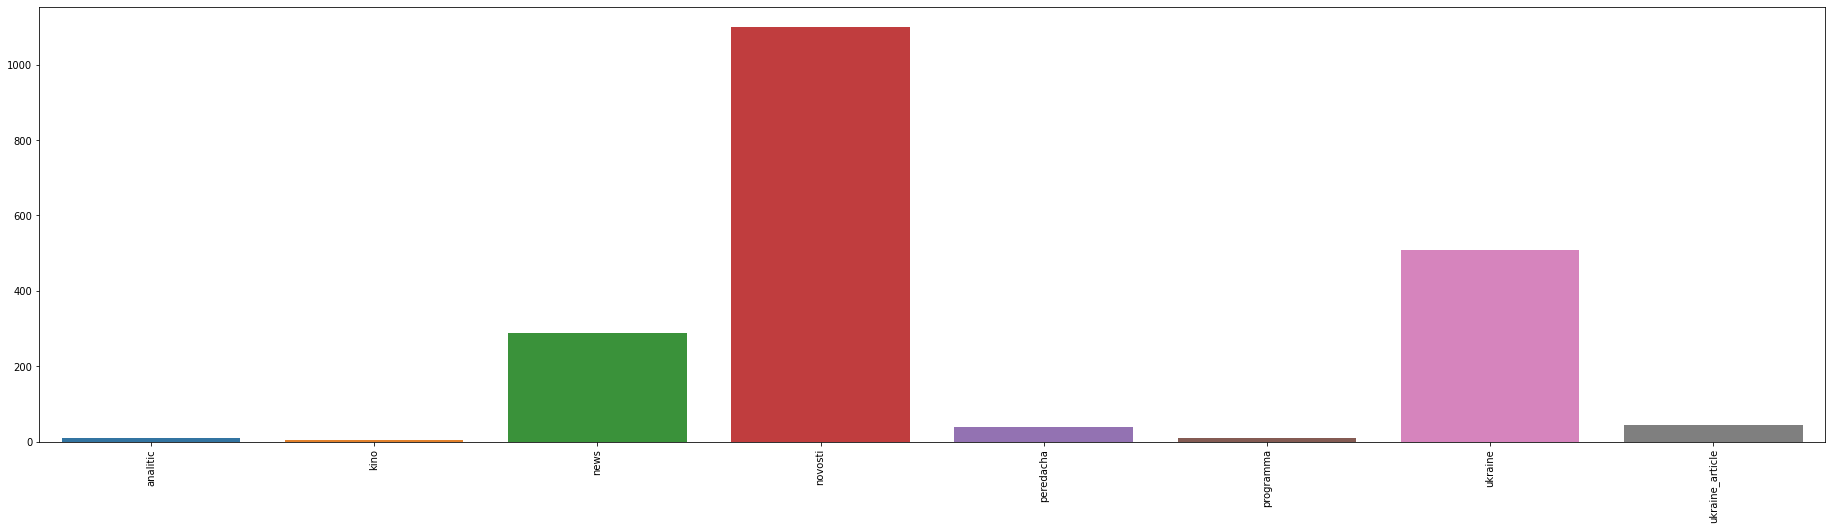

In [16]:
fig = plt.subplots(figsize=(32, 8))
sns.barplot(x=list(dictionary.values()), y=list(dictionary.keys()))
plt.xticks(rotation = 90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


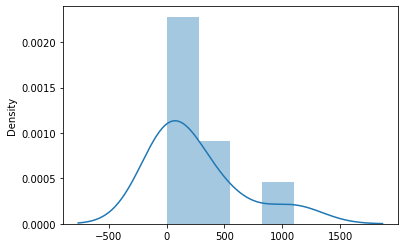

In [17]:
sns.distplot(counts)
plt.show()

## Очистка

Есть два пути - стемминг и лемматизация. Приведение слова к изначальной форме - не такое грубое решение, как отрубание частей слова, поэтому сделаем лемматизацию.

In [21]:
# перед тем, как использовать лемматизатор Наташи, нужно явно инициализировать компоненты для 
# сегментации текста
segmenter = Segmenter()
emb = NewsEmbedding()
# анализа морфологии
morph_tagger = NewsMorphTagger(emb)
# анализа синтаксиса
syntax_parser = NewsSyntaxParser(emb)
morph_vocab = MorphVocab()

In [22]:
clean_articles = []

for article in shortened_df['text']:
  # заменим непонятный символ
  article = article.replace("\\x97",'')
  # удалим разные знаки, оставим только слова 
  article = re.sub("[^а-яА-я]",' ', article)
  # все слова - с маленькой буквы
  article = article.lower()

  # подготовим документ к лемматизации
  doc = Doc(article)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  doc.parse_syntax(syntax_parser)

  # лемматизация
  for token in doc.tokens:
    token.lemmatize(morph_vocab)

  #создадим список для очищенного лемматизированного текста, при этом будем удалять стоп-слова
  article = [_.lemma for _ in doc.tokens if not _.lemma in stopwords.words("russian")]

  # добавим строку к очищенным текстам
  clean = ' '.join(article)
  clean_articles.append(clean)


In [23]:
shortened_df['text'] = clean_articles

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
shortened_df['text'][0]

'пятница российский спортсмен юношеский олимпийский игра китайский нанкин завоевать восемь награда золотой серебряный бронзовые тяжелоатлет хетаг хугаев завоевать золото весовой категория кг розалия насретдинов первенствовать плавание дистанция метр вольный стиль евгений рылов принести россиянин серебро плавание дистанция метр спина вместе александр садовниковый розалия насретдинов дарья устинов стать второй смешанный комбинированный эстафета х м штангистка светлана щербаков завоевать серебро весовой категория свыше кг кроме дарья устинов завоевать бронза плавание дистанция м вольный стиль антон чупковый награда достоинство дистанция м спина итог шестой день сборная россия сохранить второй место командный зачет счет медаль золотой серебряный бронзовый лидировать китайский команда награда'

## Векторизуем

In [26]:
# Initialize a vectorizer object
tfidf = TfidfVectorizer()

# Fit transform the clean article to create vectors
article_vectors = tfidf.fit_transform(clean_articles)

In [27]:
article_vectors.shape

(2000, 23828)

## Снижение размерности

In [29]:
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate=200.0)
vecs_redused = tsne.fit_transform(article_vectors)

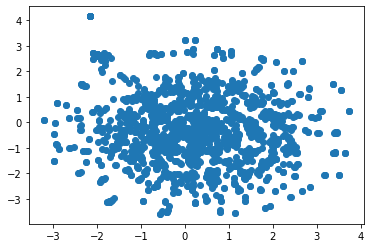

In [30]:
plt.scatter(vecs_redused[:, 0], vecs_redused[:, 1])
plt.show()

что такое Explained Variance VS Number Of Features в снижении размерности

## Пробуем разные кластеризации

In [31]:
tsne_df = pd.DataFrame(vecs_redused, columns=['comp1','comp2'])

### DBSCAN

In [92]:
eps = np.arange(0.25, 5.25)
min_samples_range = range(30, 70, 5)
hyper = []
for eps in eps:
    for min_samples in min_samples_range:
        dbs = DBSCAN(eps = eps, min_samples=min_samples)
        labels_dbs = dbs.fit_predict(vecs_redused)
        try:
          hyper.append([eps, min_samples, silhouette_score(vecs_redused, labels_dbs)])
        except ValueError: 
          pass

In [101]:
a = 0
eps = 0
samples = ''
for i in range(len(hyper)):
  if hyper[i][2] > a:
    a = hyper[i][2]
    eps = hyper[i][0]
    samples = hyper[i][1]
print(a, eps, samples)

0.5597242 1.25 30


In [97]:
dbs = DBSCAN(eps = 1.25, min_samples=30)
labels_dbs = dbs.fit_predict(vecs_redused)

In [98]:
shortened_df['labels_dbs'] = labels_dbs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Визуализация

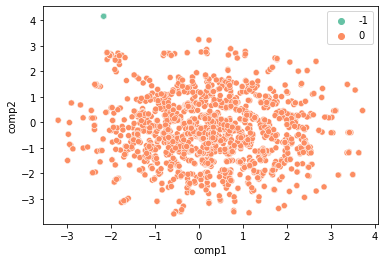

In [99]:
sns.scatterplot(x=tsne_df['comp1'],y=tsne_df['comp2'],hue=labels_dbs,palette='Set2')
plt.show()

### Гауссова смесовая

In [61]:
n_components_range = range(3, 10)
cv_types = ['tied', 'diag']
hyper = []
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm_pred = gmm.fit_predict(vecs_redused)
        hyper.append([n_components, cv_type, silhouette_score(vecs_redused, gmm_pred)])

In [73]:
a = 0
num = 0
method = ''
for i in range(len(hyper)):
  if hyper[i][2] > a:
    a = hyper[i][2]
    num = hyper[i][0]
    method = hyper[i][1]
print(a, num, method)

0.3609699 7 diag


In [75]:
gmm = GaussianMixture(n_components=7, covariance_type='diag')
labels_gmm = gmm.fit_predict(vecs_redused)

In [76]:
shortened_df['labels_gmm'] = labels_gmm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


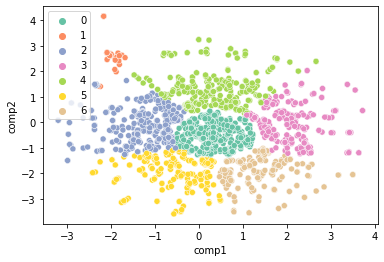

In [77]:
sns.scatterplot(x=tsne_df['comp1'],y=tsne_df['comp2'],hue=labels_gmm,palette='Set2')
plt.show()

### K-Means

Подберем k по инерции (сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся) и силуэту:

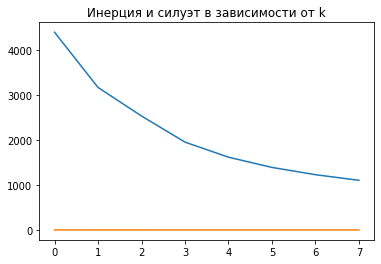

In [55]:
inertia = [KMeans(n_clusters=k).fit(vecs_redused).inertia_ for k in range(2,10)]
score = [silhouette_score(vecs_redused, KMeans(n_clusters=k).fit_predict(vecs_redused)) for k in range(2,10)]
#можно взять 3 кластера
plt.plot(inertia)
plt.plot(score)
plt.title('Инерция и силуэт в зависимости от k');
plt.show()

In [58]:
km = KMeans(n_clusters=3)
labels_km = km.fit_predict(vecs_redused)

In [59]:
shortened_df['labels_km'] = labels_km

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


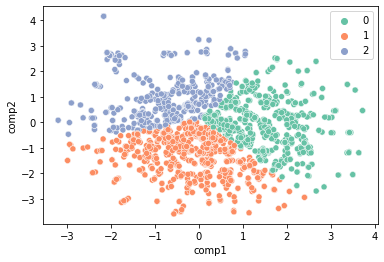

In [60]:
sns.scatterplot(x=tsne_df['comp1'],y=tsne_df['comp2'],hue=labels_km,palette='Set2')
plt.show()